Import the necessary libraries

In [1]:
# Standard library imports
from __future__ import absolute_import, division, print_function
from time import process_time
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics

# Particledist library imports
from particledist import ParticleDistributionCMSEfficient
from particledist import MassDistribution
from particledist import PFNDist

#Import processing time function
from time import process_time

Using TensorFlow backend.
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/apps/rhel7/Python-GPU

Define a helper function to divide up samples and get the AUC scores for each sample

In [2]:
#Inputs: (list of event masses, event info on the particle level, size of each sample in events, number of samples)
#Ouputs: matrix of AUC scores. Dimensions: (num_samples, num_bins-1), where num_bins is # of bins in histogram

def generate_AUCs_from_sample(mass_list, event_list, sample_size, num_samples):
    index_list = range(0, len(mass_list))
    AUC_scores = []

    for i in range(num_samples): # Repeat num_sample times
        
        #Take a random sample of 50,000 events. Find the corresponding masses and event info
        sample_index = random.sample(index_list, sample_size)
        sample_masses = [mass_list[i] for i in sample_index]
        sample_events = [event_list[i] for i in sample_index]
        
        #Create histogram out of 50,000 events, extract jet data, and pad the jet data arrays
        sample_mass_dist = MassDistribution.MassDistribution(sample_masses, sample_events)
        sample_mass_dist.divide_mass_bins(100, 3000)
        sample_mass_dist.extract_jets_into_mass_bins()
        sample_mass_dist.pad_jet_arrays(160)
        
        #Generate AUC scores for the histogram, append to AUC_score matrix
        sample_PFN_dist = PFNDist.PFNDist(sample_mass_dist.padded_jet_arrays)
        sample_PFN_dist_AUC_scores = sample_PFN_dist.generate_AUCs(12000, 3000)
        AUC_scores.append(sample_PFN_dist_AUC_scores)

    return AUC_scores

Load jets, sort by event, keep only 2-jet events, and calculate event masses

In [3]:
t1_start = process_time() #Start timing the process

# Transverse momentum, jet etas, and quality specs below
specs = ['350 <= corr_jet_pts <= 450', 'abs_jet_eta < 1.9', 'quality >= 2']

amount = 0.8 # Sets 4/5 of the dataset to be loaded, about 3 million jets total

sim = ef.mod.load(*specs, dataset='sim', amount=amount) # Actually loads the jet data with given specs and amount

# Prints info about the number of jets, the max jet mass, and the min jet mass, to check the jets loaded correctly
'''
My output:
Number of jets:  2962176
Max:  155.7694702
Min:  3.663904428
'''
print("Number of jets: ", len(sim))
print("Max: ", np.amax(sim.jet_ms))
print("Min: ", np.amin(sim.jet_ms))

t1_stop = process_time() # Stop timing the process 

# Prints the time it took to load the jets -- should take about 20 minutes with 8 vCPUs
print("Elapsed time while loading events, in seconds:", t1_stop-t1_start)

print()

#Complete data pre-processing (group jets by event, choose 2-jet events, and calculate mass)
CMS_80p_dist = ParticleDistributionCMSEfficient.ParticleDistributionCMSEfficient(sim)
CMS_80p_dist.choose_2jet_events()
CMS_80p_dist.add_event4vectors_2jet()
CMS_80p_dist.event_mass_2jet()

Number of jets:  2962176
Max:  155.7694702
Min:  3.663904428
Elapsed time while loading events, in seconds: 968.873254824

Starting event processing
Event processing finished
Starting 4-vector conversion
4-vector conversion finished
Elapsed time during event and 4-vector parsing in seconds: 87.136670041


Check event mass distribution across all 2-jet events. Distribution should look normal, with a slight right tail

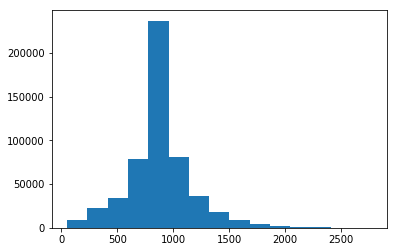

In [4]:
plt.hist(CMS_80p_dist.event_mass_2jet, bins = 15)
plt.show()

Form mass distributions and calculate AUCs for samples of 50,000, 70,000, and 100,000 events. We brought the number of samples down to 20 so that the code would run quicker, but it will still take a few hours.

In [12]:
t1_start = process_time() # Start timing the process

'''The printed output indicates the AUCs across each event sample distribution. There will be 20 lines of 
output per each AUC analysis run, since we're taking 20 samples. There should be 60 lines of output total, 
since we're running 3 analyses, each on 3 different sample sizes.'''

# Generate AUC scores for 20 samples of 50,000 events
AUC_scores_50000 = generate_AUCs_from_sample(CMS_80p_dist.event_mass_2jet,
                                             CMS_80p_dist.event_list_2, 50000, 20)

# Generate AUC scores for 20 samples of 70,000 events
AUC_scores_70000 = generate_AUCs_from_sample(CMS_80p_dist.event_mass_2jet,
                                             CMS_80p_dist.event_list_2, 70000, 20)

# Generate AUC scores for 20 samples of 100,000 events
AUC_scores_100000 = generate_AUCs_from_sample(CMS_80p_dist.event_mass_2jet,
                                             CMS_80p_dist.event_list_2, 100000, 20)

print("--- %s seconds ---" % (process_time() - t1_start)) # Stop timing the process - should take 2-3 hours at least


[0.5117752604601418, 0.49221141353870634, 0.4918736540115213, 0.4942474868564354, 0.533008707056656]
[0.5008468781503094, 0.5026023391812866, 0.5117048412285268, 0.48994350038138224, 0.5086982652464618]
[0.5001727745401723, 0.5151588771729837, 0.5125094137813416, 0.4908226274336991, 0.49615076860035]
[0.4795723234002536, 0.5066222373973047, 0.5274833196110109, 0.5028253954634323]
[0.4787257183716932, 0.48482206967524644, 0.5140218781285196, 0.5057091476976954]
[0.5150568893935596, 0.5092982904671814, 0.49970976273221346, 0.5332556881592555, 0.5202003859106653]
[0.5050946024752154, 0.48761260217246866, 0.5133814414597604, 0.4753645139422295, 0.4775131547457]
[0.5048479364189555, 0.5054731289366372, 0.4968614296210992, 0.5061930070527559, 0.5027721317173426]
[0.5209985808944142, 0.5151114421249964, 0.4897975491907327, 0.5278459845607459]
[0.5170876642314532, 0.4898906357282217, 0.48579992569421976, 0.5159110836677987, 0.4965876159049616]
[0.5260605179960018, 0.5019355255707165, 0.5047365

'\nAUC_scores_25000 = generate_AUCs_from_sample(CMS_80p_dist.event_mass_2jet,\n                                             CMS_80p_dist.event_list_2, 25000, 50)\n\nAUC_scores_10000 = generate_AUCs_from_sample(CMS_80p_dist.event_mass_2jet,\n                                             CMS_80p_dist.event_list_2, 10000, 50)\n\n'

Define helper function to calculate AUC stats given the matrices of AUC scores calculated above

In [2]:
#Inputs: (AUC score matrix, expected/most common amount of bins)
#Ouputs: Matrix showing mean and standard deviation of AUC scores across the consecutive bin pairs

def calculate_stats(AUC_scores, expected_length):
    
    #Only keep AUC score rows that match the expected_length
    keep_indices = []
    for i in range(len(AUC_scores)):
        if len(AUC_scores[i]) == expected_length:
            keep_indices.append(i)
    AUC_scores_array_sorted = []
    for index in keep_indices:
        AUC_scores_array_sorted.append(AUC_scores[index])
    
    #Calculate mean and standard deviation for each bin pair of AUC scores
    AUC_scores_array_sorted = np.array(AUC_scores_array_sorted)    
    AUC_scores_array_sorted = np.transpose(AUC_scores_array_sorted)
    AUC_stats = []
    for AUC_score_bin in AUC_scores_array_sorted:
        AUC_stats.append([statistics.mean(AUC_score_bin), statistics.stdev(AUC_score_bin)])

        
    return AUC_stats

Calculate means and uncertainties in AUC for each sample size of events with the above helper function

In [5]:
#Calculate AUC stats for each sample size (expected number of bins are already filled in)
stats_50000 = calculate_stats(AUC_scores_50000, 4) 
stats_25000 = calculate_stats(AUC_scores_70000, 5) 
stats_10000 = calculate_stats(AUC_scores_100000, 8) 

#Stats are printed in the format [[Bin1Mean, Bin1Stdev], [Bin2Mean, Bin2Stdev], ...]
print("AUC Stats for sample size of 100000 [Mean, Stdev]")
print(stats_70000)
print()

print("AUC Stats for sample size of 25000 [Mean, Stdev]")
print(stats_25000)
print()

print("AUC Stats for sample size of 10000 [Mean, Stdev]")
print(stats_10000)
print()

AUC Stats for sample size of 100000 (Mean, Stdev)
[[0.5105322370156745, 0.013605272375471784], [0.5007858870433575, 0.013873346940985992], [0.5079765725123272, 0.015898960203635334], [0.5093272223973182, 0.010919041453624654], [0.5060702279759798, 0.012452826811080306]]


'\nprint()\nprint("AUC Stats for sample size of 25000 (Mean, Stdev)")\nprint(stats_25000)\nprint()\nprint("AUC Stats for sample size of 10000 (Mean, Stdev)")\nprint(stats_10000)\nprint()\n'